In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import adjusted_rand_score
from matplotlib import markers,colors

### Utility Functions

In [149]:
def convertTimeToSec(timeVec):
    # Convert time from hh:mm:ss string to number of seconds
    return sum([a * b for a, b in zip(
            map(int, timeVec.decode('utf-8').split(':')), [3600, 60, 1])])

def loadData(filename):
    # Load data from CSV file into numPy array, converting times to seconds
    timestampInd = 2

    data = np.loadtxt(filename, delimiter=",", dtype=float, skiprows=1, 
                      converters={timestampInd: convertTimeToSec})

    return data

# Method referenced from ChatGPT
def predictPosition(latitude, longitude, direction, speed, time_diff):
    # Predict latitude and longitude of a ship at specified amount of time after last known position
    # direction = 0 or 3600 means north (+ lat), 900 is east (+ lon), 1800 is south (- lat), 2700 is west (- lon)
    earth_radius = 3440.065 # Earth radius in nautical miles
    angle = math.radians(direction / 10) # Convert angle from degrees to radians
    displacement = ((speed/10) * time_diff) / 3600.0
    new_latitude = latitude + (displacement / earth_radius) * math.cos(angle)
    new_longitude = longitude + (displacement / earth_radius) * math.sin(angle)
    return new_latitude, new_longitude

def velocityError(prev, curr):
    # Represent speed and angle as a vector and take squared magnitude of difference
    size = len(prev) # Assume prev and curr are same length
    prev_angle = math.radians(prev[size - 1] / 10)
    curr_angle = math.radians(curr[size - 1] / 10)
    prev_speed = prev[size - 2] / 10
    curr_speed = curr[size - 2] / 10
    prev_velocity = np.array([prev_speed*math.cos(prev_angle), prev_speed*math.sin(prev_angle)])
    curr_velocity = np.array([curr_speed*math.cos(curr_angle), curr_speed*math.sin(curr_angle)])
    return (np.linalg.norm(prev_velocity - curr_velocity) ** 2) * (10 ** -6) # Scale with position error

def plotVesselTracks(latLon, clu=None):
    # Plot vessel tracks using different colors and markers with vessels
    # given by clu
    
    n = latLon.shape[0]
    if clu is None:
        clu = np.ones(n)
    cluUnique = np.array(np.unique(clu), dtype=int)
    
    plt.figure()
    markerList = list(markers.MarkerStyle.markers.keys())
    
    normClu = colors.Normalize(np.min(cluUnique),np.max(cluUnique))
    for iClu in cluUnique:
        objLabel = np.where(clu == iClu)
        imClu = plt.scatter(
                latLon[objLabel,0].ravel(), latLon[objLabel,1].ravel(),
                marker=markerList[iClu % len(markerList)],
                c=clu[objLabel], norm=normClu, label=iClu)
    plt.colorbar(imClu)
    plt.legend().set_draggable(True)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

def plotVesselTracks3D(features, labels, c=[]):
    if len(c) == 0:
        c = np.unique(labels)
    indices = [i for i, x in enumerate(labels) if x in c]
    figure = plt.figure()
    ax = plt.axes(projection = '3d')
    ax.scatter(features[indices, 1], features[indices, 2], features[indices, 0], c=labels[indices], s=1)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Time')

### Load Data

In [3]:
ship_data = loadData('set1.csv') # OBJECT_ID, VID, TIME, LAT, LON, SPEED_OVER_GROUND, COURSE_OVER_GROUND
ship_data_2 = loadData('set2.csv') # OBJECT_ID, VID, TIME, LAT, LON, SPEED_OVER_GROUND, COURSE_OVER_GROUND
ship_data_3 = loadData('set3NoVID.csv')
ship_data[0]

array([ 1.0000000e+00,  1.0000800e+05,  5.0400000e+04,  3.6906850e+01,
       -7.6089022e+01,  1.0000000e+00,  1.6410000e+03])

### Time Analysis

In [4]:
def plotTimeDifferences(data, title):
    time_diff = []
    initial_time = []
    for vid in np.unique(data[:, 1]):
        vid_rows = data[data[:, 1] == vid]
        initial_time.append(vid_rows[0, 2] - data[0, 2])
        for i in range(1, len(vid_rows)):
            time_diff.append(vid_rows[i, 2] - vid_rows[i-1, 2])
    #bins = range(int(min(time_diff)), int(max(time_diff) + 1))
    bins = np.logspace(np.log10(min(time_diff)), np.log10(max(time_diff)), num=len(set(time_diff)) // 4)
    plt.hist(time_diff, bins=bins, edgecolor='black')
    plt.xlabel('Adjacent Time Difference')
    plt.xscale('log')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()
    print(initial_time)
    print(time_diff[0:10])
    print(np.sum(time_diff == 0))
    print(np.sum(data[:, 5] >= 1020))

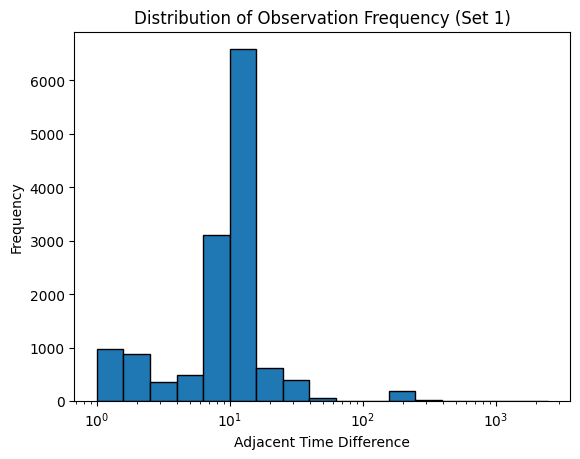

[954.0, 10386.0, 1347.0, 6.0, 1.0, 1.0, 6.0, 0.0, 10758.0, 172.0, 198.0, 172.0, 3.0, 53.0, 0.0, 0.0, 3.0, 49.0, 0.0, 9.0]
[7.0, 2.0, 1.0, 4.0, 3.0, 3.0, 11.0, 10.0, 19.0, 9.0]
0
0


In [192]:
# Data set 1
plotTimeDifferences(ship_data, 'Distribution of Observation Frequency (Set 1)')

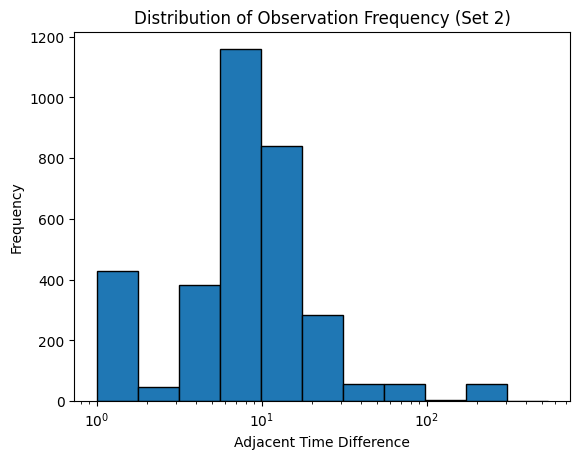

[0.0, 41.0, 134.0, 2023.0, 5429.0, 6377.0, 8206.0, 9672.0]
[60.0, 30.0, 29.0, 61.0, 30.0, 30.0, 29.0, 31.0, 29.0, 1.0]
0
0


In [193]:
# Data set 2
plotTimeDifferences(ship_data_2, 'Distribution of Observation Frequency (Set 2)')

Overall, it seems as though the vast majority of ships transmit data with no more than a 1 minute gap between transmissions. However, the time at which ships start transmission seems like it can be more or less whenever. The gap between each transmission per ship also seems too inconsistent to use, even if certain ships have a bit of a pattern. Given that no transmissions occur from the same ship in the same second, we can use this fact to treat each transmission occurring in the same second as coming from a different ship. Further, we can assume that no ships reach the saturation limit for speed of 102.2 knots since none of the ships from the first 2 data sets do.

### Position Prediction Analysis

In [7]:
def plot_position_errors(data, set_number):
    errors = []
    lat_errors = []
    lon_errors = []
    time_diff = []
    for vid in np.unique(data[:, 1]):
        vid_rows = data[data[:, 1] == vid]
        for i in range(1, len(vid_rows)):
            prev = vid_rows[i-1, :]
            curr = vid_rows[i, :]
            time = curr[2] - prev[2]
#             direction = (curr[6] + prev[6]) / 2
#             speed = (curr[5] + prev[5]) / 2
#             prediction = predictPosition(prev[3], prev[4], direction, speed, time)
            prediction = predictPosition(prev[3], prev[4], prev[6], prev[5], time)
            actual = (curr[3], curr[4])
            lat_error = actual[0] - prediction[0]
            lon_error = actual[1] - prediction[1]
            lat_errors.append(lat_error)
            lon_errors.append(lon_error)
            errors.append(lat_error**2 + lon_error**2)
            time_diff.append(time)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(lat_errors, bins=10, edgecolor='black')
    plt.title('Histogram of Latitude Errors (Set %d)' % set_number)
    plt.xlabel('Latitude Errors')
    plt.ylabel('Frequency')
    plt.yscale('log')

    plt.subplot(1, 3, 2)
    plt.hist(lon_errors, bins=10, edgecolor='black', color='green')
    plt.title('Histogram of Longitude Errors (Set %d)' % set_number)
    plt.xlabel('Longitude Errors')
    plt.ylabel('Frequency')
    plt.yscale('log')

    plt.subplot(1, 3, 3)
    plt.scatter(time_diff, errors, marker='o')
    plt.title('Adjacent Time Difference vs Position Errors (Set %d)' % set_number)
    plt.xlabel('Time Difference')
    plt.ylabel('Errors')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='both', axis='both')
#     slope, intercept = np.polyfit(time_diff, errors, 1)
#     line_of_best_fit = np.poly1d([slope, intercept])
#     plt.plot(time_diff, line_of_best_fit(time_diff), color='red')

    plt.tight_layout()
    plt.show()
    
    print('Mean latitude error:', sum(lat_errors) / len(lat_errors))
    print('Mean longitude error:', sum(lon_errors) / len(lon_errors))
    print('Mean error:', sum(errors) / len(errors))

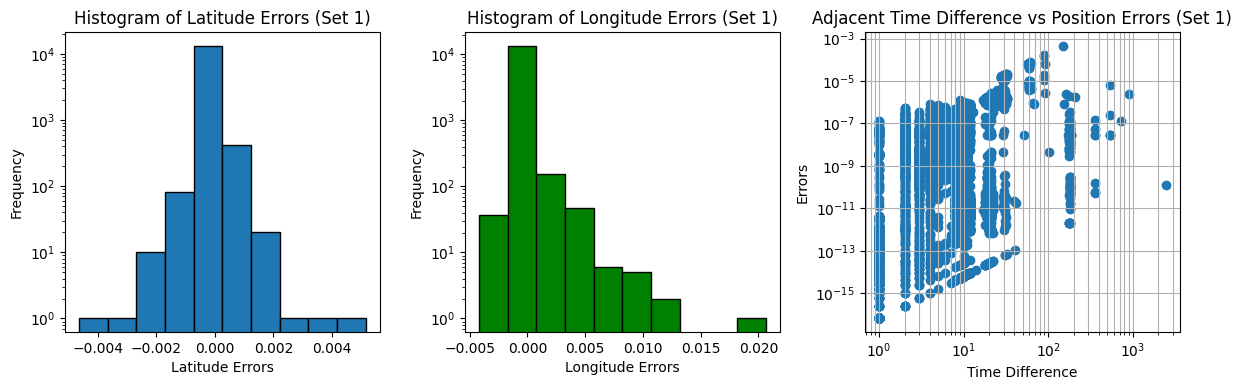

Mean latitude error: -1.3679743885814232e-05
Mean longitude error: 1.910184434304343e-05
Mean error: 3.018539368277576e-07


In [8]:
# Data set 1
plot_position_errors(ship_data, 1)

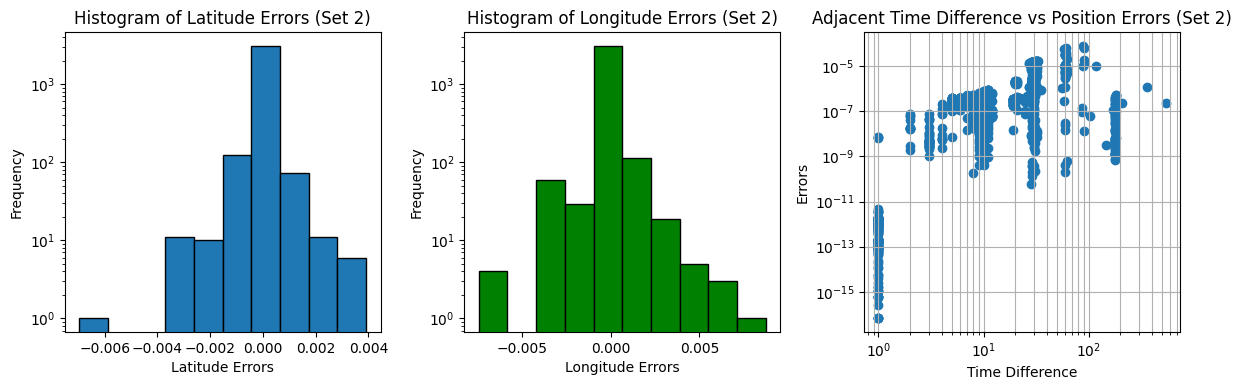

Mean latitude error: 5.271557821191372e-05
Mean longitude error: -0.00019918650272209135
Mean error: 8.563361877851724e-07


In [9]:
# Data set 2
plot_position_errors(ship_data_2, 2)

The latitude and longitude errors are roughly evenly distributed around 0 which indicates low bias in our predicted position method. The scatter plot suggests a somewhat linearly increasing relationship between adjacent time difference and error in prediction, though only on the logarithmic scale. Additionally, it isn't really worth averaging speed or direction between the adjacent transmissions since it only very slightly decreases the mean squared error (3.018539368277576e-07 vs 3.018208609515292e-07 for set 1 not averaging vs averaging, and 8.563361877851724e-07 vs 8.562981799288442e-07 for set 2) and will likely pose a greater risk of misclassifying ships that aren't supposed to be in a cluster as in that cluster.

### Angle/Speed Analysis

In [10]:
def plot_velocity_errors(data, set_number, pairwise=False):
    errors = []
    time_diff = []
    for vid in np.unique(data[:, 1]):
        vid_rows = data[data[:, 1] == vid]
        for i in range(1, len(vid_rows)):
            prev = vid_rows[i-1, :]
            curr = vid_rows[i, :]
            errors.append(velocityError(prev, curr))
            time_diff.append(curr[2] - prev[2])

    pairwise_errors = []
    pairwise_time_diff = []
    if pairwise:
        for i in range(len(data)):
            for j in range(i):
                prev = data[j, :]
                curr = data[i, :]
                pairwise_errors.append(velocityError(prev, curr))
                pairwise_time_diff.append(curr[2] - prev[2])
    
    if pairwise:
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
    plt.scatter(time_diff, errors, marker='o')
    plt.title('Adjacent Time Difference vs Velocity Errors (Set %d)' % set_number)
    plt.xlabel('Time Difference')
    plt.ylabel('Errors')
    plt.xscale('log')
    plt.yscale('log')
    
    if pairwise:
        plt.subplot(1, 2, 2)
        plt.scatter(pairwise_time_diff, pairwise_errors, marker='o')
        plt.title('Pairwise Time Difference vs Velocity Errors (Set %d)' % set_number)
        plt.xlabel('Time Difference')
        plt.ylabel('Errors')
        plt.xscale('log')
        plt.yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    print('Mean adjacent error:', sum(errors) / len(errors))
    if pairwise:
        print('Mean pairwise error:', sum(pairwise_errors) / len(pairwise_errors))

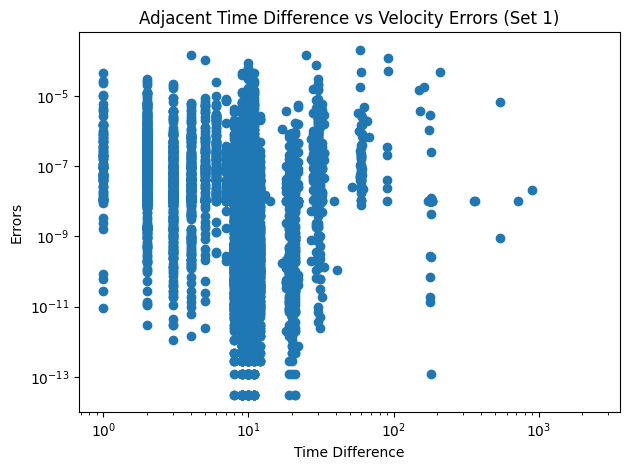

Mean adjacent error: 2.508834040196439e-07


In [11]:
# Data set 1
plot_velocity_errors(ship_data, 1)

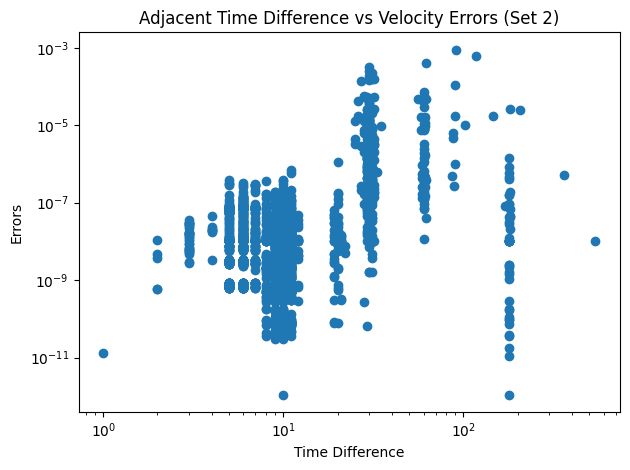

Mean adjacent error: 1.5982362024979707e-06


In [12]:
# Data set 2
plot_velocity_errors(ship_data_2, 2)

### Algorithm

In [200]:
# def predict(testFeatures):
#     size = len(testFeatures)
#     predictions = np.zeros(size)
#     classes = [] # most recent transmission from each ship/class
#     class_index = 0 # number of classes, to keep track of next new class index
#     # Maybe sort testFeatures by time just to be safe -- not needed if structured like set3NoVID.csv
#     for i in range(size):
#         entry = testFeatures[i, :]
#         best_diff = float('inf')
#         best_c = None
#         for c in range(len(classes)):
#             time_diff = entry[0] - classes[c][0]
#             if time_diff > 0:
#                 actual = (classes[c][1], classes[c][2])
#                 prediction = predictPosition(entry[1], entry[2], entry[4], entry[3], time_diff)
#                 error = (actual[0] - prediction[0])**2 + (actual[1] - prediction[1])**2
#                 if error < 0.001 and error < best_diff: # Not a new ship
#                     # Maybe keep track of all less than error threshold and discriminate further based on angle/speed
#                     best_diff = error
#                     best_c = c
#         if best_c == None: # Set as start of new class
#             classes.append(entry)
#             best_c = class_index
#             class_index += 1
#         else:
#             classes[best_c] = entry
#         predictions[i] = best_c
#     return predictions

def predict(testFeatures, k=0, testLabels=[], forward=True, eligibles=[]):
    size = len(testFeatures)
    predictions = np.zeros(size)
    classes = [] # most recent transmission from each ship/class
    actual_classes = []
    class_index = 0 # number of classes, to keep track of next new class index
    # Maybe sort testFeatures by time just to be safe -- not needed if structured like set3NoVID.csv
    start = 0
    increment = 1
    end = size
    if forward == False:
        start = size - 1
        increment = -1
        end = -1
    for i in range(start, end, increment):
        entry = testFeatures[i, :]
        best_diff = float('inf')
        best_c = None
        num_eligible = 0
        for c in range(len(classes)):
            time_diff = abs(entry[0] - classes[c][0])
            if time_diff > 0:
                actual = (entry[1], entry[2])
                angle = classes[c][4]
                if forward == False:
                    angle = (classes[c][4] + 1800) % 3600
                prediction = predictPosition(classes[c][1], classes[c][2], angle, classes[c][3], time_diff)
                error = (actual[0] - prediction[0])**2 + (actual[1] - prediction[1])**2
                threshold = 0.0001
                if error < threshold and error < best_diff: # Not a new ship
                    # Maybe keep track of all less than error threshold and discriminate further based on angle/speed
                    best_diff = error
                    best_c = c
                    num_eligible += 1
        eligibles.append(num_eligible)
        if best_c == None: # Set as start of new class
            classes.append(entry)
            if len(testLabels) > 0:
                if testLabels[i] in actual_classes:
                    # Incorrectly adding a new class
                    print('Incorrectly adding new class')
                    print('New entry:', entry)
                    print('Last entry:', classes[actual_classes.index(testLabels[i])])
                    print()
                actual_classes.append(testLabels[i])
            best_c = class_index
            class_index += 1
        else:
            if len(testLabels) > 0:
                if testLabels[i] not in actual_classes:
                    # Should be adding a new class
                    print('Incorrectly failing to add new class')
                    print('New entry:', entry)
                    print('Connected entry:', classes[best_c])
                    print()
                elif actual_classes.index(testLabels[i]) != best_c:
                    # Adding to wrong class
                    print('Adding to incorrect class')
                    print('New entry:', entry)
                    print('Connected entry:', classes[best_c])
                    print('Last entry:', classes[actual_classes.index(testLabels[i])])
                    print()
            classes[best_c] = entry
        predictions[i] = best_c
    # Deal with case when there's too many clusters (reassign smallest ones)
    classes, counts = np.unique(predictions, return_counts=True)
    if k > 0 and classes.size > k:
        remove_classes = np.argsort(counts)[:(classes.size - k)]
        classes_recent = [np.zeros(5) for i in range(len(classes))]
        start = 0
        increment = 1
        end = size
        if forward == False:
            start = size - 1
            increment = -1
            end = -1
        for i in range(start, end, increment):
            entry = testFeatures[i, :]
            if predictions[i] in remove_classes:
                best_diff = float('inf')
                best_c = None
                for c in range(len(classes_recent)):
                    if classes_recent[c][0] == 0:
                        continue
                    time_diff = abs(entry[0] - classes_recent[c][0])
                    if time_diff > 0:
                        actual = (entry[1], entry[2])
                        angle = classes_recent[c][4]
                        if forward == False:
                            angle = (classes_recent[c][4] + 1800) % 3600
                        prediction = predictPosition(classes_recent[c][1], classes_recent[c][2], angle,
                                                     classes_recent[c][3], time_diff)
                        error = (actual[0] - prediction[0])**2 + (actual[1] - prediction[1])**2
                        if error < best_diff:
                            best_diff = error
                            best_c = c
                predictions[i] = best_c
            else:
                classes_recent[int(predictions[i])] = entry
    return predictions

def evaluate(features, labels, predictions, threeD = False):
    predNumVessels = np.unique(predictions).size
    ari = adjusted_rand_score(labels, predictions)
    print(f'Adjusted Rand index for estimated K = {predNumVessels}: ' + f'{ari}')
    if threeD:
        plotVesselTracks3D(features, predictions)
        plt.title('Vessel tracks by cluster')
        plotVesselTracks3D(features, labels)
        plt.title('Vessel tracks by label')
    else:
        plotVesselTracks(features[:,[2,1]], predictions)
        plt.title('Vessel tracks by cluster')
        plotVesselTracks(features[:,[2,1]], labels)
        plt.title('Vessel tracks by label')

Adjusted Rand index for estimated K = 20: 0.3501115751866301


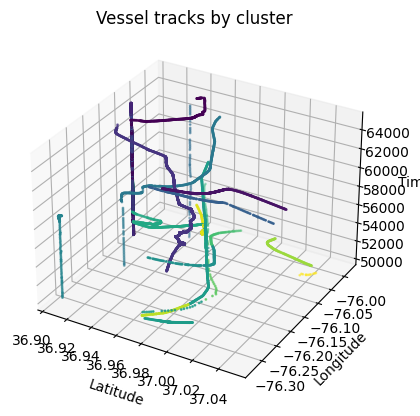

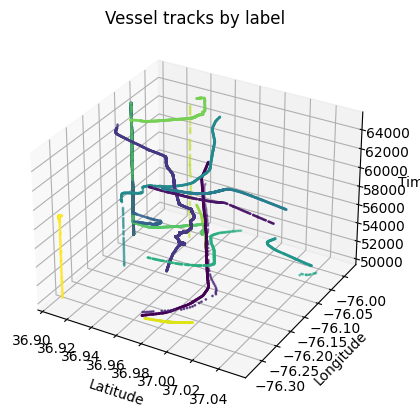

In [195]:
# Data set 1
features = ship_data[:,2:] # TIME, LAT, LON, SPEED_OVER_GROUND, COURSE_OVER_GROUND
labels = ship_data[:,1]
evaluate(features, labels, predict(features, forward=False, k=20), True)

Adjusted Rand index for estimated K = 8: 1.0


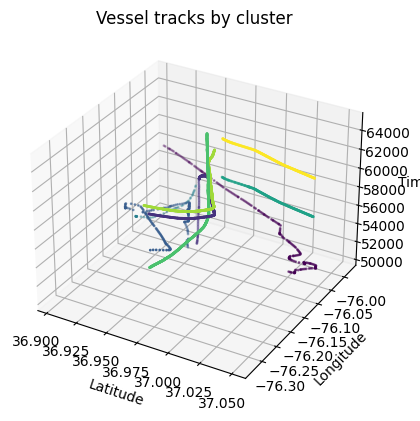

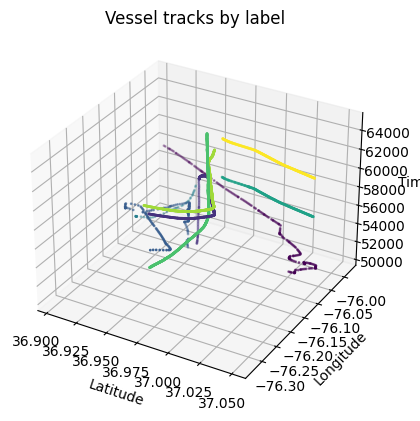

In [191]:
# Data set 2
features = ship_data_2[:,2:]
labels = ship_data_2[:,1]
evaluate(features, labels, predict(features, forward=True), True)

Adjusted Rand index for estimated K = 24: 0.4510992309724384


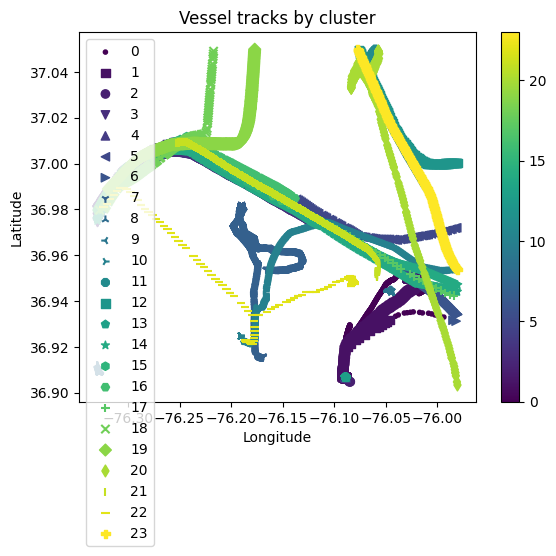

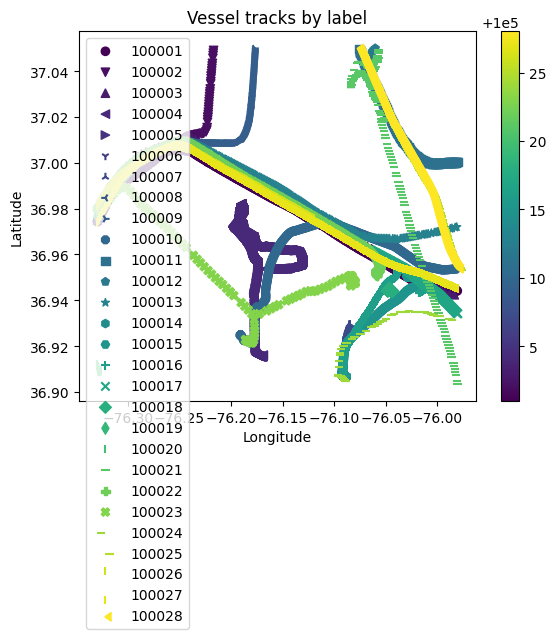

In [98]:
# Data set 1 & 2
both_data = np.r_[loadData('set1.csv'), loadData('set2.csv')]
features = both_data[:, 2:]
labels = both_data[:,1]
evaluate(features, labels, predict(features))

Adjusted Rand index for estimated K = 10: 0.0


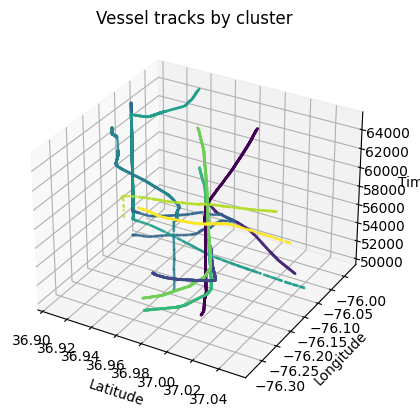

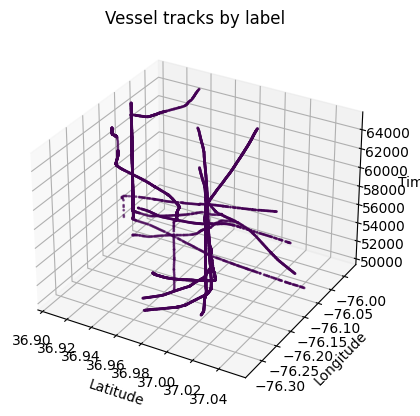

In [199]:
# Data set 3
features = ship_data_3[:,2:]
labels = ship_data_3[:,1]
evaluate(features, labels, predict(features, forward=True), True)

### Number of Eligible Points (under Threshold) Analysis

Text(0, 0.5, 'Frequency')

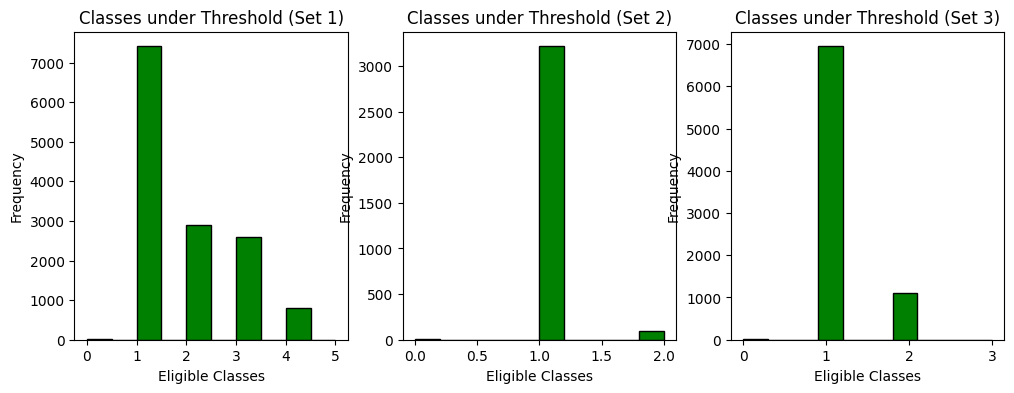

In [111]:
plt.figure(figsize=(12, 4))
eligibles = []
features = ship_data[:,2:]
predict(features, eligibles=eligibles)
plt.subplot(1, 3, 1)
plt.hist(eligibles, bins=10, edgecolor='black', color='green')
plt.title('Classes under Threshold (Set 1)')
plt.xlabel('Eligible Classes')
plt.ylabel('Frequency')

eligibles = []
features = ship_data_2[:,2:]
predict(features, eligibles=eligibles)
plt.subplot(1, 3, 2)
plt.hist(eligibles, bins=10, edgecolor='black', color='green')
plt.title('Classes under Threshold (Set 2)')
plt.xlabel('Eligible Classes')
plt.ylabel('Frequency')

eligibles = []
features = ship_data_3[:,2:]
predict(features, eligibles=eligibles)
plt.subplot(1, 3, 3)
plt.hist(eligibles, bins=10, edgecolor='black', color='green')
plt.title('Classes under Threshold (Set 3)')
plt.xlabel('Eligible Classes')
plt.ylabel('Frequency')

### Things to Try:
- Forwards and backwards checking combined somehow
- Take into account angle/speed for thresholding
- See if ships that haven't sent a transmission in a while tend to be stationary